In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from scipy import stats

data=pd.read_csv('BTC-USD.csv',parse_dates=["Date"],sep=',')

#convert dates from string to datetime objects
data["Date"]=pd.to_datetime(data["Date"])

#keep only the date part of datetime object
data["Date"]=data["Date"].dt.date

#drop the nan values
data.isna().sum()
data.dropna(axis=0,how='any',inplace=True)
data.isna().sum()


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [23]:
data['Time_dummy']=np.arange(len(data.index))
data['Time_dummy']=data['Time_dummy'].astype('float64')
data['Change']=data["Close"].pct_change().fillna(0)
data.reset_index(drop=True,inplace=True)
data.drop('Adj Close',inplace=True,axis=1)
data.drop(0,axis=0,inplace=True)
data

,Date,Open,High,Low,Close,Volume,Time_dummy,Change
1,2016-12-14,780.005005,782.033997,776.838989,781.481018,7.597900e+07,1.0,0.001185
2,2016-12-15,780.070007,781.434998,777.802002,778.088013,8.158010e+07,2.0,-0.004342
3,2016-12-16,778.963013,785.031982,778.963013,784.906982,8.360820e+07,3.0,0.008764
4,2016-12-17,785.166016,792.508972,784.864014,790.828979,7.898980e+07,4.0,0.007545
5,2016-12-18,791.007996,794.737000,788.026001,790.530029,6.052440e+07,5.0,-0.000378
...,...,...,...,...,...,...,...,...
1818,2021-09-12,50450.082030,50797.164060,47358.351560,47672.121090,2.960358e+10,1818.0,-0.056087
1819,2021-10-12,47642.144530,50015.253910,47023.699220,47243.304690,3.096601e+10,1819.0,-0.008995
1820,2021-11-12,47264.632810,49458.210940,46942.347660,49362.507810,2.577587e+10,1820.0,0.044857
1821,2021-12-12,49354.855470,50724.867190,48725.851560,50098.335940,2.193922e+10,1821.0,0.014907


In [24]:
prepro=preprocessing.MinMaxScaler()
data_float=data.loc[:, data.dtypes=='float64']
data_scaled=pd.DataFrame(prepro.fit_transform(data_float), index=data_float.index,columns=data_float.columns)
data_scaled['Date']=data['Date']
data_scaled.drop('Change', axis=1,inplace=True)
data_scaled['Change']=data['Change']


In [36]:
#reseting the index to use predict function of tsa package
data_scaled.reset_index(drop=True,inplace=True)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

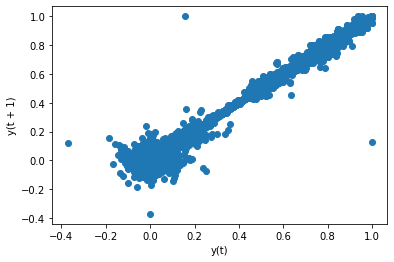

In [37]:
from pandas.plotting import lag_plot,autocorrelation_plot
lag_plot(data_scaled.loc[:,data_scaled.columns!='Date'])

c:\Users\pchrk\OneDrive\Desktop\cs\3rd\ml\ml-env\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


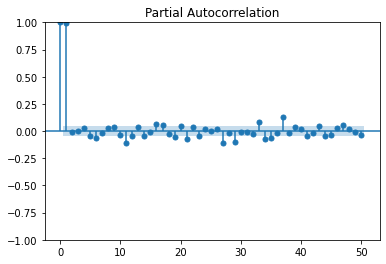

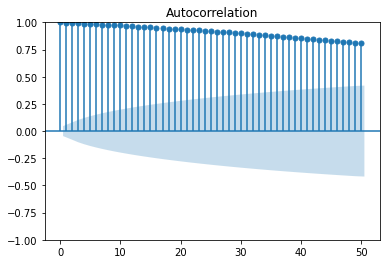

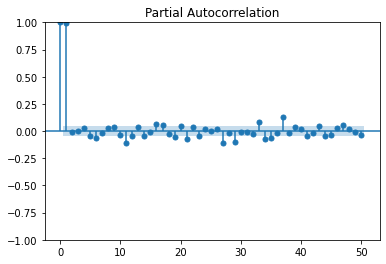

In [38]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(data_scaled["Close"], lags=50)
plot_pacf(data_scaled["Close"],lags=50)

Από τα διαγράμματα συσχέτισης και αυτοσυσχέτισης βλέπουμε ότι θα μπορούσαμε να χρησιμοποιήσουμε την τιμή $y_{t-1}$ για την πρόβλεψη της επόμενης τιμής κλεισίματος

In [39]:
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


In [41]:
ar1_train_data,ar1_test_data=data_scaled["Close"].iloc[:-100],data_scaled["Close"].iloc[-100:]

optimal_ar_model=ar_select_order(ar1_train_data,maxlag=30)
optimal_ar_model_fitted=optimal_ar_model.model.fit()
print(optimal_ar_model_fitted.summary())
print("Optimal number of lags is %s" % optimal_ar_model_fitted.ar_lags)

# ar1_predictions=optimal_ar_model_fitted.predict(start=len(ar1_train_data),end=len(ar1_train_data)+len(ar1_test_data)-1)
# for i in range(len(ar1_predictions)):
#     print('predicted=%f, expected=%f' %(ar1_predictions.iloc[i],ar1_test_data.iloc[i]))
# rmse=mean_squared_error(ar1_test_data,ar1_predictions)
# rmse_root=np.sqrt(rmse)
# print("mean squared error is: %.3f and root is %.3f" %(rmse,rmse_root))

# plt.plot(ar1_test_data)
# plt.plot(ar1_predictions, color='red')


                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                 1722
Model:                     AutoReg(3)   Log Likelihood                5150.891
Method:               Conditional MLE   S.D. of innovations              0.012
Date:                Thu, 20 Jan 2022   AIC                         -10291.782
Time:                        17:03:48   BIC                         -10264.535
Sample:                             3   HQIC                        -10281.701
                                 1722                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.041      0.298      -0.000       0.001
Close.L1       0.9419      0.024     39.151      0.000       0.895       0.989
Close.L2       0.1292      0.033      3.923      0.0

In [48]:
#in sample predictions
y_true=ar1_train_data[-100:]

In [49]:

in_sample_predictions=optimal_ar_model_fitted.predict(start=1622,end=1721,dynamic=False)
in_sample_predictions

1622    0.566024
1623    0.524784
1624    0.505142
1625    0.520940
1626    0.547481
          ...   
1717    0.694849
1718    0.693067
1719    0.718868
1720    0.728780
1721    0.737762
Length: 100, dtype: float64

In [50]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# predicting the accuracy score
score=r2_score(y_true,in_sample_predictions)
print('r2 score is: ', score)
print('mean s error is   ',mean_squared_error(y_true,in_sample_predictions))
print('root mean squared error is==',np.sqrt(mean_squared_error(y_true,in_sample_predictions)))

r2 score is:  0.9402133981259463
mean s error is    0.0004836434066628291
root mean squared error is== 0.02199189411266863


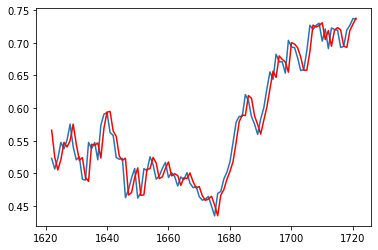

In [54]:
plt.plot(y_true)
plt.plot(in_sample_predictions, color='red')

Text(0.5, 1.0, 'Prediction vs real values')

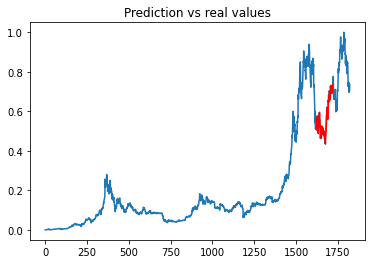

In [56]:
plt.plot(data_scaled['Close'])
plt.plot(in_sample_predictions, color='red')
plt.title("Prediction vs real values")

In [62]:
#out of sample prediction and testing
out_of_sample_predictions=optimal_ar_model_fitted.forecast(100)
out_of_sample_predictions


1722    0.737462
1723    0.737798
1724    0.738370
1725    0.738860
1726    0.739370
          ...   
1817    0.785631
1818    0.786142
1819    0.786654
1820    0.787166
1821    0.787678
Length: 100, dtype: float64

In [63]:
y_true=ar1_test_data
score=r2_score(y_true,out_of_sample_predictions)
print('r2 score is: ', score)
print('mean s error is   ',mean_squared_error(y_true,out_of_sample_predictions))
print('root mean squared error is==',np.sqrt(mean_squared_error(y_true,out_of_sample_predictions)))

r2 score is:  -0.0457848055938983
mean s error is    0.01252340282516072
root mean squared error is== 0.11190801054956129


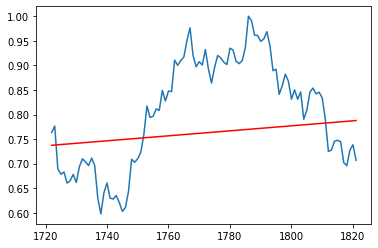

In [64]:
plt.plot(y_true)
plt.plot(out_of_sample_predictions, color='red')

Παρατηρούμε πως οι προβλέψεις για out of sample παρατηρήσεις είναι μια ευθεία γραμμή.Αυτή η συμπεριφορά είναι αναμενόμενη αφου δεν υπάρχει κάποια εποχική τάση στα δεδομένα μας .Το μοντέλο απλά χρησιμοποιεί τις προηγούμενες τιμές σταθμισμένες και λαμβάνει μια σταθερά ανοδική τιμή κλεισίματος.

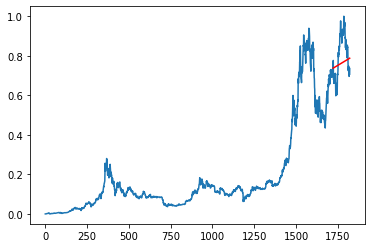

In [65]:
plt.plot(data_scaled["Close"])
plt.plot(out_of_sample_predictions,color='red')